## Analyze A/B Test Results - Hanan AlTuwaijri


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


For this project, I aim to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [43]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [44]:
df=pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Use the cell below to find the number of rows in the dataset.

In [45]:
#number of rows in the dataset:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [46]:
#unique users:
unique_users=df.user_id.nunique()
unique_users

290584

d. The proportion of users converted.

In [236]:
converted_users=df.loc[df['converted'] == 1].user_id.count()
proportion=(converted_users/unique_users)*100
print( proportion ,"%")

12.126269856564711 %


e. The number of times the `new_page` and `treatment` don't match.

In [48]:
df.query('group =="treatment" and landing_page =="old_page"').count()[0]+df.query('group =="control" and landing_page =="new_page"').count()[0]


3893

new_page and treatment don't match: **3893**

f. Do any of the rows have missing values?

In [49]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

>**NO**, rows have missing values

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [50]:
# New filterded Dataset
df3=df.query('group =="treatment" and landing_page == "new_page"')
df4=df.query('group =="control" and landing_page == "old_page"')
df2 = df3.append(df4, sort=False)
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [51]:

# Double Check all of the correct rows were removed - this should be 0
print ( df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0] 
# the droped rows should be equel 3893
,"\n the droped rows equel = ",df.shape[0]-df2.shape[0])

0 
 the droped rows equel =  3893


`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [52]:
df2.user_id.nunique()

290584

 >290585-290584= **1** 

b. There is one **user_id** repeated in **df2**.  What is it?

In [53]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [54]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [67]:
df2.user_id[df2.user_id==773192]
df2.user_id.drop_duplicates( keep='first', inplace=True )

In [72]:
df2.user_id.count()

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [57]:
convP=df2.loc[df2.converted==1].count()[0]/df2.shape[0]

b. Given that an individual was in the `control` group, what is the probability they converted?

In [144]:
contconv=df2.query('group=="control" and converted==1').count()[0]/df2.query('group=="control"').count()[0]
contconv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [145]:
treatconv=df2.query('group=="treatment" and converted==1').count()[0]/df2.query('group=="treatment"').count()[0]
treatconv

0.11880724790277405

d. What is the probability that an individual received the new page?

In [60]:
newP=df2.loc[df2.landing_page=="new_page"].count()[0]/df2.shape[0]
newP

0.5000636646764286

In [61]:
oldP=df2.loc[df2.landing_page=="old_page"].count()[0]/df2.shape[0]
oldP

0.4999363353235714

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>NO, I think we need more examenation and we need to try all the best analysis in this data 
becouse in this point the `old page` have grater probability with convertings coustomers .


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

 > $$H_0: p_{new} - p_{old} <= 0$$$$H_1: p_{new} - p_{old}  > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [62]:
Pnew=df2.converted.sum()/df2.shape[0]
Pnew

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [93]:
Pold=df2.converted.sum()/df2.shape[0]
Pold

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [66]:
Nnew=df2.query('group == "treatment"').count()[1]
Nnew

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [73]:
Nold=df2.query('group == "control"').count()[1]
Nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [141]:
#Pnew =0.1195 and 1-Pnew =0.8805
new_page_converted = np.random.choice(2, size = 145311, p=[0.8805, 0.1195])

new_page_converted


array([0, 0, 0, ..., 0, 1, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [142]:
#Pold =0.1195 and 1-Pold =0.8805
old_page_converted = np.random.choice(2, size = 145274, p=[0.8805, 0.1195])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [148]:
obs_diffs= new_page_converted.mean() - old_page_converted.mean()# differences computed in from p_new and p_old
obs_diffs

0.0005338566998037697

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [124]:
p_diffs = np.random.binomial(Nnew, Pnew, 10000)/Nnew - np.random.binomial(Nold, Pold, 10000)/Nold


array([ 0.00128394, -0.00148981, -0.00163413, -0.00088434, -0.00031927])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

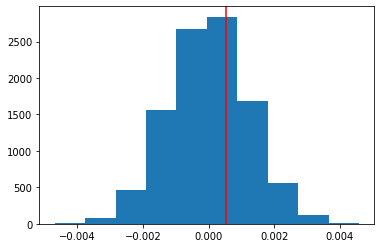

In [151]:
plt.hist(p_diffs)
plt.axvline(x= obs_diff, color='r')




j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [146]:
actu_diffs=treatconv-contconv

(actu_diffs<p_diffs).mean()


0.9052

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- This is P-value 0.9052.
- A P-value is the probability of getting the results you did (or more extreme results) given that the null hypothesis is true.

>**For accepting null hypothesis p-value should be greater than 0.05 we are calculate that almost 90% of the population is above the real diffrence which suggested that new-page is not doing significantly better than the old page. New page is worse than old page, so we should stick to the null hyposthesis as p-value is large.**


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [165]:
import statsmodels.api as sm
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = len(df2.query('landing_page=="old_page"')) #rows_associated with old_page
n_new = len(df2.query('landing_page=="new_page"')) 


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [164]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller')
#display z_score and p_value
print(z_score,p_value)

1.3116075339133115 0.905173705140591


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>**Yes ,
z_score is less than critical value of 95% confidence and it's the same still P-value 0.9. we accept null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?


>**Logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.


In [207]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2['intercept']=1

In [208]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [209]:
explanatory=df2[['intercept', 'ab_page']]
regression_model=sm.Logit( df2['converted'] ,explanatory)
results=regression_model.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [210]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Sun, 28 Jun 2020   Pseudo R-squ.:               8.085e-06
Time:                        00:28:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

In [231]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985115
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

>**in Part ||| the Logistic regression** 
>                             $$H_0: p_{new} - p_{old} <= 0$$$$H_1: p_{new} - p_{old}  > 0$$
>                                           
>                                    

>**in Part ||** 
>                            $$H_0: p_{new} - p_{old} <= 0$$$$H_1: p_{new} - p_{old}  > 0$$
>                                           
                                            

>**The p-value associated with ab_page : 0.190 and in part|| :0.9052**\
>Becouse :\
>In *Part II*, the test identified whether the average conversion rates differ between old page and new page  visitors >in the population.\
>A logistic regression estimates how the conversion rate varies by page visited.\
>*We're comparing the differences between two samples as opposed to the relationship between a dependent and >independent variable. Moreover, the simulation and the z-test were one-sided tests, whereas the regression was not .*

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**



>**It can't tell us about an option we haven’t considered like : the users (location , age ,education-level ، gender .. etc ) .\
  And it can also produce bias results when tested on existing users, due to factors like change aversion and novelty effect**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.


>**The Answer :**
>**None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.**

In [ ]:
countries=pd.read_csv('countries.csv')
df2=df2.set_index('user_id').join(countries.set_index('user_id'))

In [227]:
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,CA
user_id,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,US,0,0,1
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,US,0,0,1
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,0,US,0,0,1
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,US,0,0,1
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,US,0,0,1


In [228]:
df2[['US','UK','CA']]=pd.get_dummies(df2['country']) 
ml=sm.Logit(df2['converted'] , df2[['intercept','ab_page','US','UK']])
results2=ml.fit()


Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [229]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Sun, 28 Jun 2020   Pseudo R-squ.:               2.324e-05
Time:                        03:59:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.744      0.457      -0.016       0.036
==============================================================================
"""

In [230]:
np.exp(results2.params)

intercept    0.136795
ab_page      0.985160
US           0.960068
UK           1.009938
dtype: float64

### Conclusions: based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])